# Plotting mospy products
### Olivia Cooper
### June 2022

In [1]:
# the basics

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import pandas as pd
import astropy
from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import ZScaleInterval
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
import read_mospy_files as rmp ## script I made to read in mospy files
plt.style.use('../cooper-paper.mplstyle')

## select a target

In [2]:
# list of spectral lines (originally from SDSS)
### shows the vacuum (rest) wavelength, the species, and the type of line

lines = pd.read_csv('../linelist.csv',delimiter=",",comment='#') # all lines
em = lines[lines['type']=='Emission'] # emission lines
ab = lines[lines['type']=='Absorption'] # absorption lines
sky = lines[lines['type']=='Sky'] # absorption lines
lines

,lambda,species,type
0,1033.820,OVI,Emission
1,1215.240,Ly alpha,Emission
2,1240.810,NV,Emission
3,1305.530,OI,Emission
4,1335.310,CII,Emission
5,1397.610,SiIV,Emission
6,1399.800,SiIV+ OIV,Emission
7,1549.480,CIV,Emission
8,1640.400,HeII,Emission
9,1665.850,OIII,Emission


In [3]:
# change to object of interest

obj_name = 'c2020_pz_0.559_24.4_810968'; zguess = 0.56; lguess = 10269.
print('working on object',obj_name,'with zguess = ',zguess,'at lambda = ',lguess,'AA')

working on object c2020_pz_0.559_24.4_810968 with zguess =  0.56 at lambda =  10269.0 AA


In [4]:
# open 1D and 2D spectrum for an object

hdu2 = fits.open('../wmmc01/wmmc01_Y_'+obj_name+'_eps.fits') # 2D spectrum
hdu1 = fits.open('../wmmc01/wmmc01_Y_'+obj_name+'_1D_00.fits') # 1D spectrum
pix_obj, wav_obj, spec1d_obj = rmp.make_1d_array(ext=0,hdu=hdu1) # object spectrum
pix_sky, wav_sky, spec1d_sky = rmp.make_1d_array(ext=1,hdu=hdu1) # sky spectrum

## plots!

candidate line at  10269.0 AA;  479.0 pix


(0.0, 44.0)

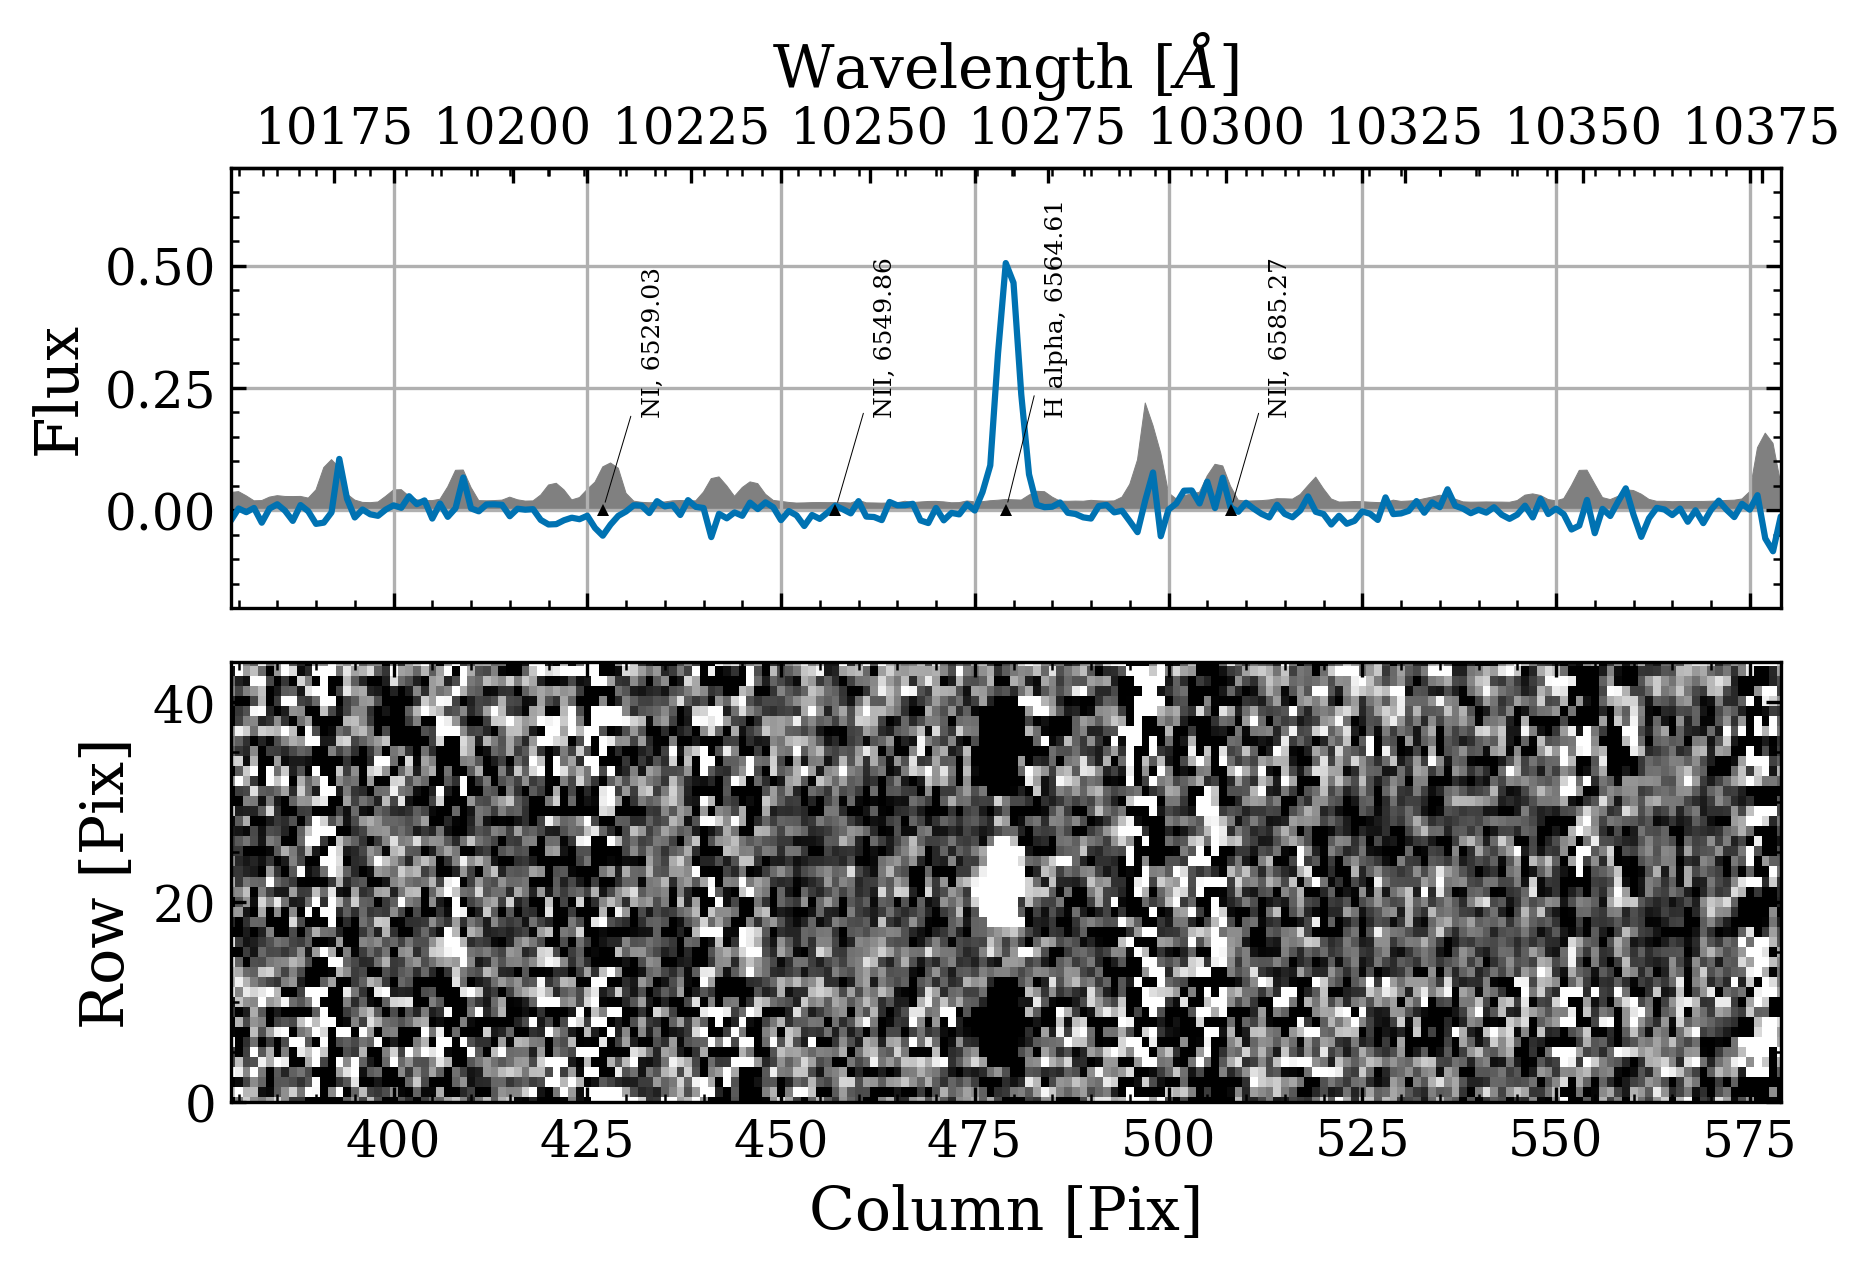

In [5]:
# plot the 1D/2D spectra with lines

### change me!
zguess = 0.5644

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

# ax1 = 1d spectrum in pixel space
ax1.plot(pix_obj,spec1d_obj)
ax1.fill_between(pix_sky, y1=spec1d_sky, y2=0, color='gray', label='sky')
ax1.set_ylabel(r'Flux')


# ax2 = 2d spectrum in pixel space
lower=-1; upper=2
sample = sigma_clip(hdu2[0].data) 
vmin = sample.mean() + lower * sample.std()
vmax = sample.mean() + upper * sample.std()
ax2.imshow(hdu2[0].data, origin='lower', cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_xlabel('Column [Pix]')
ax2.set_ylabel('Row [Pix]')
ax2.grid(False)

# secax = secondary axis for wavelength space

def forward(x):
    return np.interp(x, pix_obj, wav_obj)

def inverse(x):
    return np.interp(x, wav_obj, pix_obj)

secax = ax1.secondary_xaxis('top', functions=(forward, inverse))
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel(r'Wavelength [$\AA$]')

# convert redshifted line wavelengths into pixel space
line_pix = []
for j in range(len(lines['lambda'])):
    lline = lines['lambda'][j]*(1+zguess)
    lam = rmp.closest(wav_obj,lline)
    if np.logical_and(lline > np.min(wav_obj),lline < np.max(wav_obj)) == True:
        pix = rmp.closest(pix_obj,lam[0])[1]
    else:
        pix = np.nan
    line_pix.append(pix)

# include in lines table
lines['redshifted_pix'] = line_pix
em = lines[lines['type']=='Emission'] # emission lines
ab = lines[lines['type']=='Absorption'] # absorption lines
sky = lines[lines['type']=='Sky'] # absorption lines
   
# plot lines in pixel space
ax1.plot(ab['redshifted_pix'],0*np.ones_like(ab['redshifted_pix']),'kv',ms=3,label='absorption')
ax1.plot(em['redshifted_pix'],0*np.ones_like(em['redshifted_pix']),'k^',ms=3,label='emission')
ax1.plot(sky['redshifted_pix'],0*np.ones_like(sky['redshifted_pix']),'kd',ms=3,label='sky')

for i in range(len(lines['lambda'])):
    ax1.annotate(str(lines['species'][i]+', '+str(lines['lambda'][i])),xy=(lines['redshifted_pix'][i], 0),\
                xytext=(lines['redshifted_pix'][i]+5, 0.2),arrowprops=dict(arrowstyle="-",),size=6,rotation=90)

# mark measured line at pixel guess based on lambda guess
pguess = pix_obj[rmp.closest(wav_obj,lguess)[0]] # pixel closest to wavelength of line to center on
print("candidate line at ",lguess,'AA; ',pguess,'pix')


### change limits!
ax1.set_xlim(pguess-100,pguess+100)
ax1.set_ylim(-0.2,0.7)
ax2.set_xlim(pguess-100,pguess+100)
ax2.set_ylim(0,44) 

### uncomment to save the figure! change the path to wherever you want to put the figure
#fig.savefig('plots/wmmc01/'+obj_name+'_1D_2D_lines.png',dpi=500)

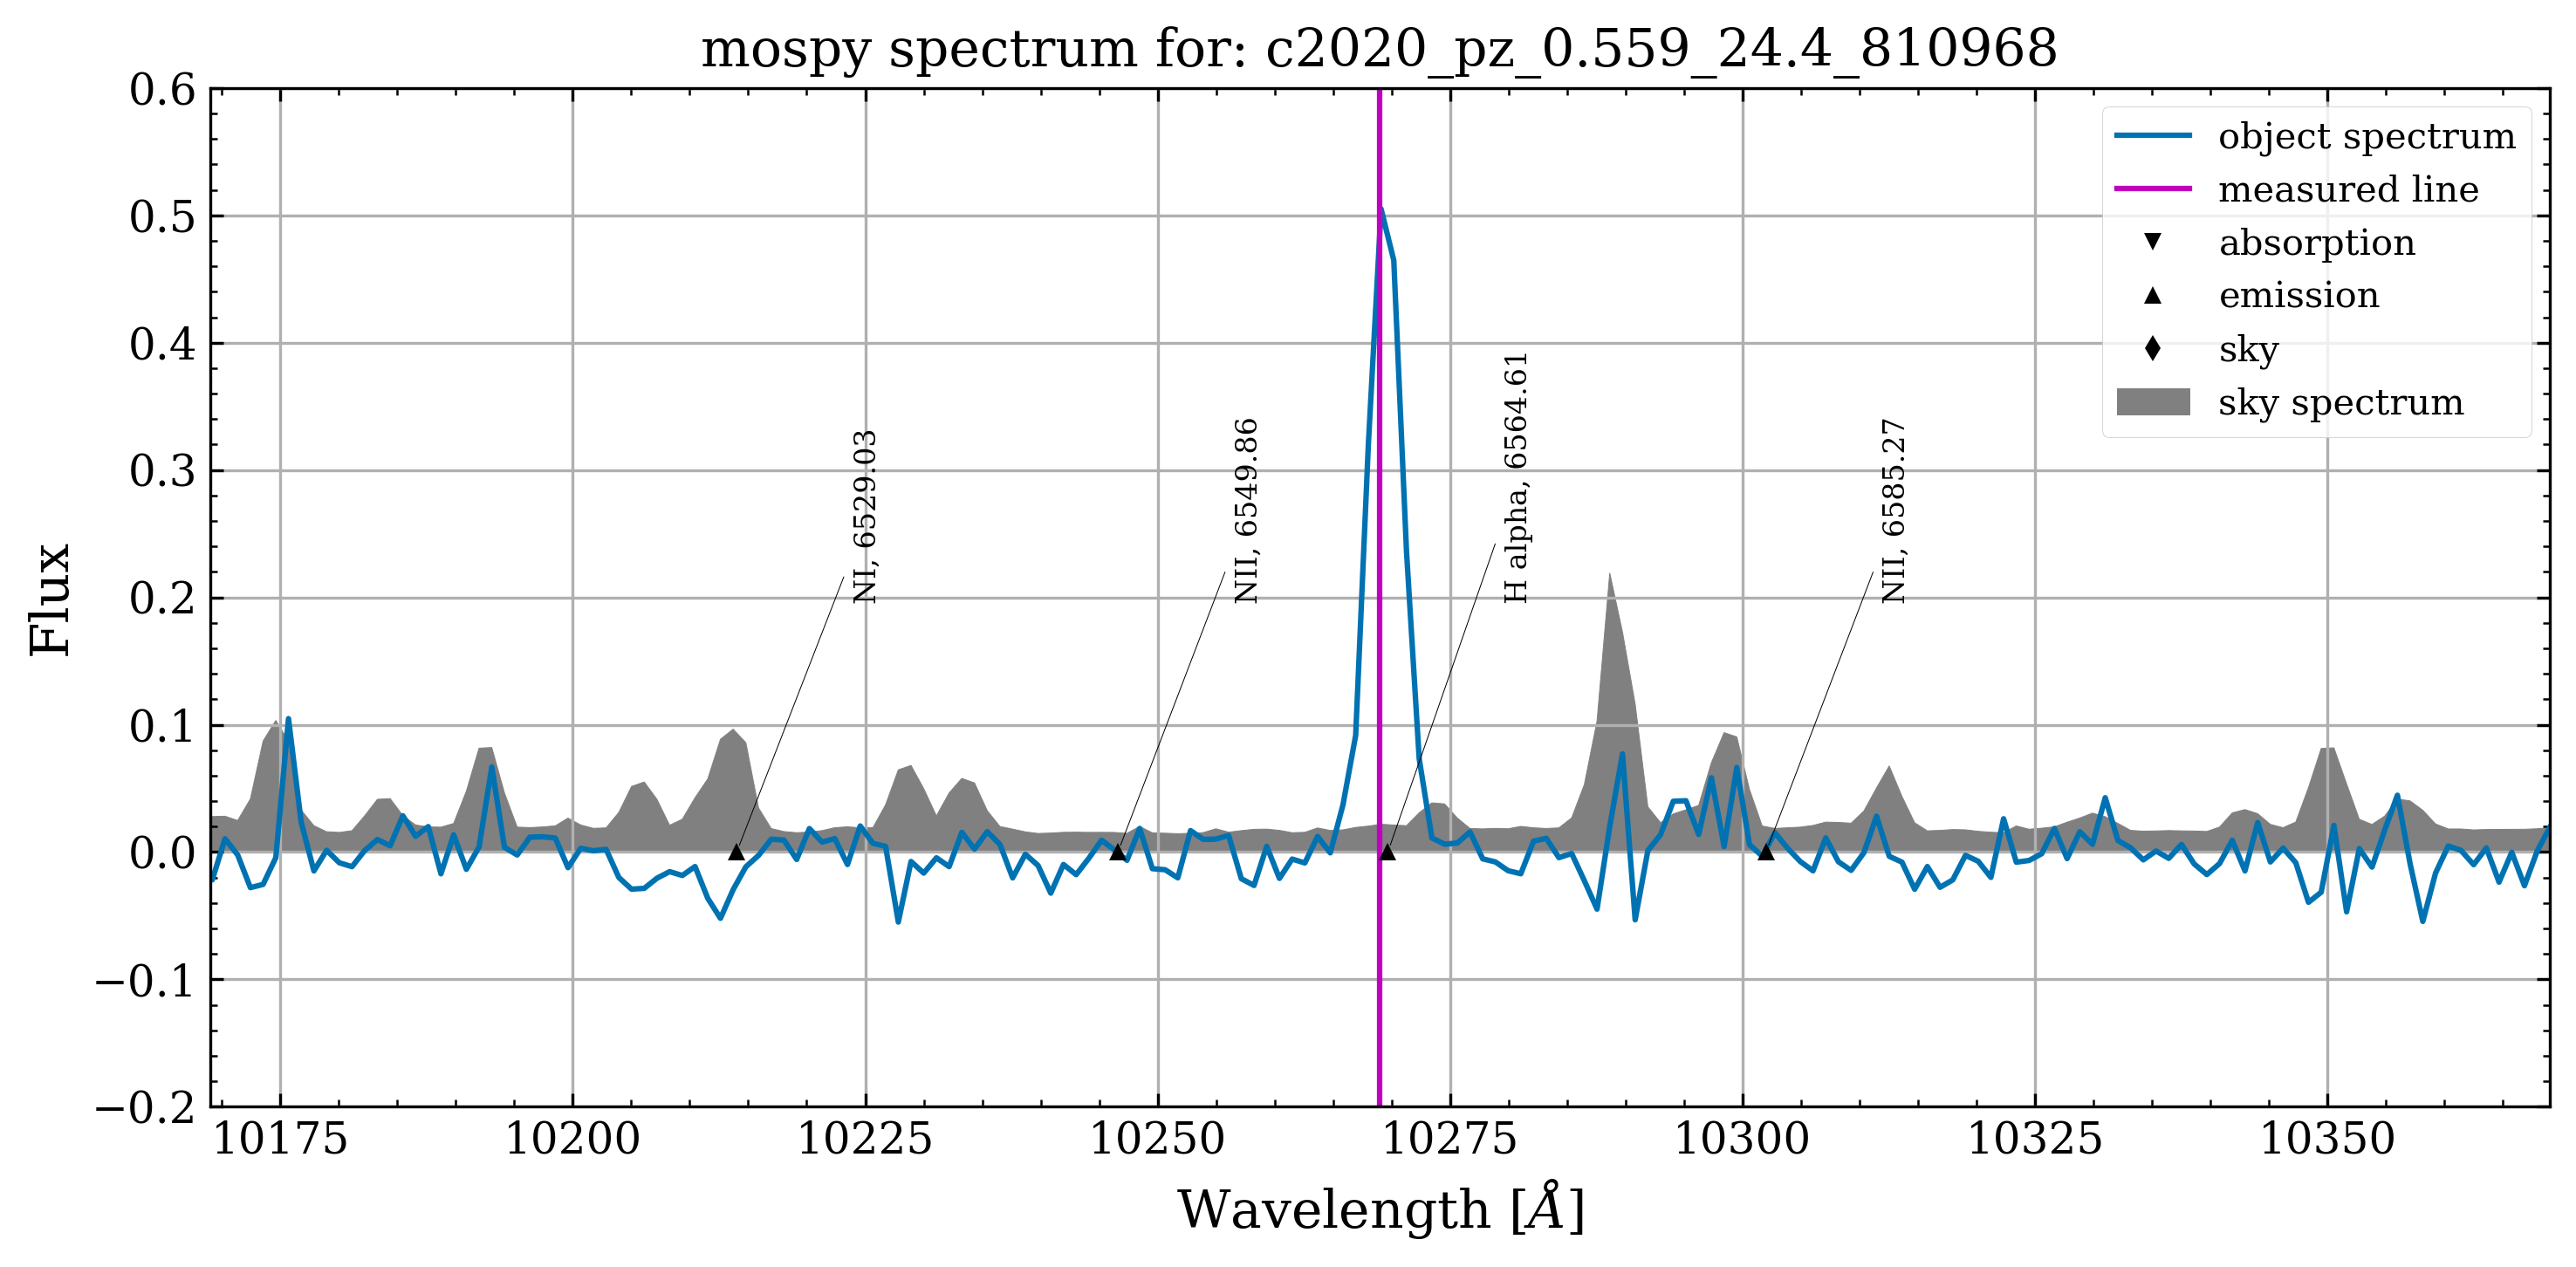

In [6]:
# plot just the 1D spectrum with sky

### change me!
zguess = 0.5644

fig = plt.figure(figsize=(10,5))
plt.title('mospy spectrum for: '+obj_name,fontsize='large')
plt.plot(wav_obj, spec1d_obj, label='object spectrum')
plt.fill_between(wav_sky, y1=spec1d_sky, y2=0, color='gray',label='sky spectrum')
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux')

plt.axvline(lguess,c='m',label='measured line')
plt.xlim(lguess-100,lguess+100)
plt.ylim(-0.2,0.6)

plt.plot(ab['lambda']*(1+zguess),0*np.ones_like(ab['lambda']),'kv',ms=5,label='absorption')
plt.plot(em['lambda']*(1+zguess),0*np.ones_like(em['lambda']),'k^',ms=5,label='emission')
plt.plot(sky['lambda']*(1+zguess),0*np.ones_like(sky['lambda']),'kd',ms=5,label='sky')

for i in range(len(lines['lambda'])):
    plt.annotate(str(lines['species'][i]+', '+str(lines['lambda'][i])),xy=(lines['lambda'][i]*(1+zguess), 0),\
                xytext=(lines['lambda'][i]*(1+zguess)+10, 0.2),arrowprops=dict(arrowstyle="-",),size=8,rotation=90)
plt.legend()